In [1]:
import re

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier

from emoji import UNICODE_EMOJI
from nltk.tokenize.casual import EMOTICON_RE

from scipy import sparse
import numpy as np
import pandas as pd
import seaborn as sns

from eventdetector.spam import StemmedTfidfVectorizer
from eventdetector.constant import stopwords

In [2]:
polluters = "../data/honeypot/content_polluters_tweets.txt"
legit_users = "../data/honeypot/legitimate_users_tweets.txt"

## Pre-processing

In [3]:
def count_currency_symbols(text):
    count = (text.count("$")
             + text.count("€")
             + text.count("£"))
    return count / len(text)

def count_capital_letter(text):
    count = 0
    for c in text:
        if c.isupper():
            count += 1
    return count / len(text)

def count_numbers(text):
    count = 0
    for c in text:
        if c.isdigit():
            count += 1
    return count / len(text)

def has_emoticon(text):
    # not-used
    re_match = EMOTICON_RE.match(text)
    emoticon = 1 if re_match else 0
    if not emoticon:
        for c in text:
            if c in UNICODE_EMOJI:
                emoticon = 1
                break
    return emoticon

def has_question_word(text):
    # not-used
    words = ["what", "when", "where", "which", "who", "why", "how"]
    question = 0
    for word in words:
        if word in text:
            question = 1
            break
    return question

def get_features(text):
    currency = count_currency_symbols(text)
    capital = count_capital_letter(text)
    number = count_numbers(text)
    return currency, capital, number

In [4]:
def get(path):
    texts = []
    features = []
    with open(path, "r") as f:
        for i, line in enumerate(f):
            if i == 50_000:
                break
            text = line.split("\t")[2]
            texts.append(text)
            feature = get_features(text)
            features.append(feature)
    return texts, features

In [5]:
names = ["currency", "capital", "number"]

In [6]:
p_texts, p_features = get(polluters)
n_texts, n_features = get(legit_users)
texts = p_texts + n_texts
features = p_features + n_features

In [7]:
n_p, n_n = len(p_texts), len(n_texts)
print("Spam:", n_p, "Not spam:", n_n)
labels = np.array([1] * n_p + [0] * n_n)

Spam: 50000 Not spam: 50000


In [8]:
features = np.array(features)
texts = np.array(texts)

In [9]:
splitted = train_test_split(texts, features, labels, test_size=0.2,
                            shuffle=True, random_state=0,
                            stratify=labels)
train_texts, test_texts, train_features, test_features, train_labels, test_labels = splitted

In [10]:
vectorizer = StemmedTfidfVectorizer(
    sublinear_tf=True, max_features=2500, stop_words=stopwords
)

In [11]:
def get_featurized_folds(features, texts, labels):
    vectorizer = StemmedTfidfVectorizer(
        sublinear_tf=True, max_features=2500, stop_words=stopwords
    )

    skf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
    datas = []
    for train_index, val_index in skf.split(features, labels):

        tra_features, val_features = features[train_index], features[val_index]
        tra_texts, val_texts = texts[train_index], texts[val_index]
        tra_labels, val_labels = labels[train_index], labels[val_index]

        tra_texts = vectorizer.fit_transform(tra_texts)
        tra_data = sparse.hstack((tra_texts, tra_features))

        val_texts = vectorizer.transform(val_texts)
        val_data = sparse.hstack((val_texts, val_features))
        datas.append((tra_data, val_data, tra_labels, val_labels))

    return datas

In [12]:
datas = get_featurized_folds(train_features, train_texts, train_labels)

## Model Evaluation

In [13]:
def print_avg(scores):
    print("Average")
    for k in scores:
        print(k + ":", round(np.mean(scores[k]), 3))

### LightGBM

In [14]:
importance = pd.DataFrame()
scores = {"acc": [], "prec": [], "rec": []}
for i, (tra_data, val_data, tra_labels, val_labels) in enumerate(datas):

    model = LGBMClassifier(
        random_state=0,
        learning_rate=0.1,
        n_estimators=5000,
        num_leaves=150,
        max_depth=200,
        min_child_samples=10,
        subsample=0.9,
        subsample_freq=1,
        colsample_bytree=0.9,
        n_jobs=-1,
    )
    model.fit(
        tra_data,
        tra_labels,
        eval_set=[(val_data, val_labels)],
        early_stopping_rounds=50,
        verbose=50,
    )

    predicted = model.predict(val_data)

    acc = accuracy_score(val_labels, predicted)
    scores["acc"].append(acc)
    prec = precision_score(val_labels, predicted)
    scores["prec"].append(prec)
    rec = recall_score(val_labels, predicted)
    scores["rec"].append(rec)
    print("Acc:", round(acc, 3), "Prec:", round(prec, 3), "Rec:", round(rec, 3))

    importance_vals = model.feature_importances_[-len(names):]
    importance_fold = pd.DataFrame({"cols": names, "fold": i,
                                    "importance": importance_vals})
    importance = pd.concat([importance, importance_fold])

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.466845
[100]	valid_0's binary_logloss: 0.454925
[150]	valid_0's binary_logloss: 0.4551
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.453953


/home/ihsan/workspace/eventdetector/env/lib/python3.7/site-packages/lightgbm/basic.py:546: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


Acc: 0.772 Prec: 0.789 Rec: 0.743
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.464745
[100]	valid_0's binary_logloss: 0.453146
[150]	valid_0's binary_logloss: 0.452827
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.452154
Acc: 0.777 Prec: 0.792 Rec: 0.753
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.46888
[100]	valid_0's binary_logloss: 0.45785
[150]	valid_0's binary_logloss: 0.458655
Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.457444
Acc: 0.771 Prec: 0.785 Rec: 0.746


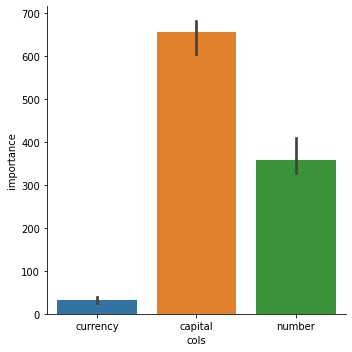

In [15]:
sns.catplot(x="cols", y="importance", kind="bar", data=importance);

In [16]:
print_avg(scores)

Average
acc: 0.773
prec: 0.788
rec: 0.747


In [17]:
tra_texts = vectorizer.fit_transform(train_texts)
tes_texts = vectorizer.transform(test_texts)
tra_data = sparse.hstack((tra_texts, train_features))
tes_data = sparse.hstack((tes_texts, test_features))
    
model = LGBMClassifier(random_state=0, n_estimators=115,
                       num_leaves=150, max_depth=200,
                       min_child_samples=10, subsample=0.9,
                       subsample_freq=1, colsample_bytree=0.9,
                       n_jobs=-1)
model.fit(tra_data, train_labels)
predicted = model.predict(tes_data)

acc = accuracy_score(test_labels, predicted)
prec = precision_score(test_labels, predicted)
rec = recall_score(test_labels, predicted)

print("Acc:", round(acc, 3),
      "Prec:", round(prec, 3),
      "Rec:", round(rec, 3))

Acc: 0.779 Prec: 0.799 Rec: 0.745


### Random Forest

In [18]:
scores = {"acc":[], "prec": [], "rec": []}
importance = pd.DataFrame()
for tra_data, val_data, tra_labels, val_labels in datas:

    model = RandomForestClassifier(
        random_state=0,
        n_jobs=-1,
        n_estimators=200,
        max_depth=200,
        min_samples_leaf=1,
    )
    model.fit(tra_data, tra_labels)

    predicted = model.predict(val_data)

    acc = accuracy_score(val_labels, predicted)
    scores["acc"].append(acc)
    prec = precision_score(val_labels, predicted)
    scores["prec"].append(prec)
    rec = recall_score(val_labels, predicted)
    scores["rec"].append(rec)
    print("Acc:", round(acc, 3), "Prec:", round(prec, 3), "Rec:", round(rec, 3))

    
    importance_vals = model.feature_importances_[-len(names):]
    importance_fold = pd.DataFrame({"cols": names, "fold": i,
                                    "importance": importance_vals})
    importance = pd.concat([importance, importance_fold])

Acc: 0.762 Prec: 0.787 Rec: 0.719
Acc: 0.774 Prec: 0.797 Rec: 0.735
Acc: 0.764 Prec: 0.783 Rec: 0.729


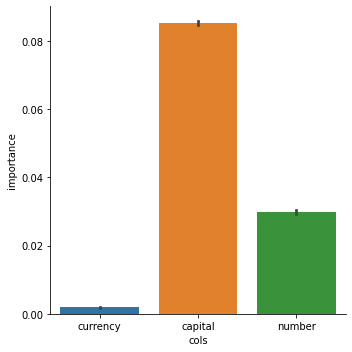

In [19]:
sns.catplot(x="cols", y="importance", kind="bar", data=importance);

In [20]:
print_avg(scores)

Average
acc: 0.767
prec: 0.789
rec: 0.728


In [21]:
tra_texts = vectorizer.fit_transform(train_texts)
tes_texts = vectorizer.transform(test_texts)
tra_data = sparse.hstack((tra_texts, train_features))
tes_data = sparse.hstack((tes_texts, test_features))

model = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=200,
                               max_depth=200, min_samples_leaf=1)
model.fit(tra_data, train_labels)
predicted = model.predict(tes_data)

acc = accuracy_score(test_labels, predicted)
prec = precision_score(test_labels, predicted)
rec = recall_score(test_labels, predicted)

print("Acc:", round(acc, 3),
      "Prec:", round(prec, 3),
      "Rec:", round(rec, 3))

Acc: 0.777 Prec: 0.803 Rec: 0.732


### Logistic regression

In [22]:
scores = {"acc":[], "prec": [], "rec": []}
importance = pd.DataFrame()
for i, (tra_data, val_data, tra_labels, val_labels) in enumerate(datas):

    model = LogisticRegression(solver="liblinear", random_state=0, max_iter=1000, C=1, penalty="l2")
    model.fit(tra_data, tra_labels)

    predicted = model.predict(val_data)

    acc = accuracy_score(val_labels, predicted)
    scores["acc"].append(acc)
    prec = precision_score(val_labels, predicted)
    scores["prec"].append(prec)
    rec = recall_score(val_labels, predicted)
    scores["rec"].append(rec)
    print("Acc:", round(acc, 3), "Prec:", round(prec, 3), "Rec:", round(rec, 3))
    
    importance_vals = model.coef_.ravel()[-len(names):]
    importance_fold = pd.DataFrame({"cols": names, "fold": i,
                                    "importance": importance_vals})
    importance = pd.concat([importance, importance_fold])

Acc: 0.751 Prec: 0.76 Rec: 0.735
Acc: 0.752 Prec: 0.759 Rec: 0.737
Acc: 0.749 Prec: 0.756 Rec: 0.735


In [23]:
print_avg(scores)

Average
acc: 0.751
prec: 0.758
rec: 0.736


In [24]:
tra_texts = vectorizer.fit_transform(train_texts)
tes_texts = vectorizer.transform(test_texts)
tra_data = sparse.hstack((tra_texts, train_features))
tes_data = sparse.hstack((tes_texts, test_features))

model = LogisticRegression(random_state=0, n_jobs=-1, max_iter=1000, tol=1e-3, C=1)
model.fit(tra_data, train_labels)
predicted = model.predict(tes_data)

acc = accuracy_score(test_labels, predicted)
prec = precision_score(test_labels, predicted)
rec = recall_score(test_labels, predicted)

print("Acc:", round(acc, 3),
      "Prec:", round(prec, 3),
      "Rec:", round(rec, 3))

Acc: 0.758 Prec: 0.767 Rec: 0.74


### Bayes

In [25]:
scores = {"acc":[], "prec": [], "rec": []}
for i, (tra_data, val_data, tra_labels, val_labels) in enumerate(datas):

    model = MultinomialNB(alpha=1e-10)
    model.fit(tra_data, tra_labels)

    predicted = model.predict(val_data)

    acc = accuracy_score(val_labels, predicted)
    scores["acc"].append(acc)
    prec = precision_score(val_labels, predicted)
    scores["prec"].append(prec)
    rec = recall_score(val_labels, predicted)
    scores["rec"].append(rec)
    print("Acc:", round(acc, 3), "Prec:", round(prec, 3), "Rec:", round(rec, 3))

Acc: 0.66 Prec: 0.632 Rec: 0.763
Acc: 0.714 Prec: 0.693 Rec: 0.766
Acc: 0.708 Prec: 0.685 Rec: 0.769


In [26]:
print_avg(scores)

Average
acc: 0.694
prec: 0.67
rec: 0.766


In [27]:
tra_texts = vectorizer.fit_transform(train_texts)
tes_texts = vectorizer.transform(test_texts)
tra_data = sparse.hstack((tra_texts, train_features))
tes_data = sparse.hstack((tes_texts, test_features))

model = MultinomialNB(alpha=1e-10)
model.fit(tra_data, train_labels)
predicted = model.predict(tes_data)

acc = accuracy_score(test_labels, predicted)
prec = precision_score(test_labels, predicted)
rec = recall_score(test_labels, predicted)

print("Acc:", round(acc, 3),
      "Prec:", round(prec, 3),
      "Rec:", round(rec, 3))

Acc: 0.715 Prec: 0.694 Rec: 0.77
